<a href="https://colab.research.google.com/github/Jeremy26/hydranets_course/blob/main/MTL_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the HydraNet Workshop 🐸🐸🐸
In this workshop, you're going to learn how to build a Neural Network that has:
* Input: **a monocular RGB Image**
* Output: **a Depth Map**, and **a Segmentation Map**

A single model, two different outputs. For that, out model will need to use a principle called Multi Task Learning.

#1 — Imports

In [1]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data.zip && unzip -q hydranets-data.zip && mv hydranets-data/* . && rm hydranets-data.zip && rm -rf hydranets-data

!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

--2021-11-02 14:53:57--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.154.44
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.154.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110752264 (106M) [application/zip]
Saving to: ‘hydranets-data.zip’

hydranets-data.zip  100%[===================>] 105.62M  10.8MB/s    in 9.8s    

2021-11-02 14:54:07 (10.8 MB/s) - ‘hydranets-data.zip’ saved [110752264/110752264]

--2021-11-02 14:54:08--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.154.82
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.154.82|:443... connected.
HTTP request sent, awaiting respon

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable

# 1 — Dataset
In the first part, I want us to focus on the Dataset we'll use to train our model. We're going to use **the NYUD Dataset**. It's made of 1449 images, depth, and segmentation samples

## Load and Visualize the Dataset

In [3]:
import glob

depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))

In [4]:
print(len(images))
print(len(depth))
print(len(seg))

1449
1449
1449


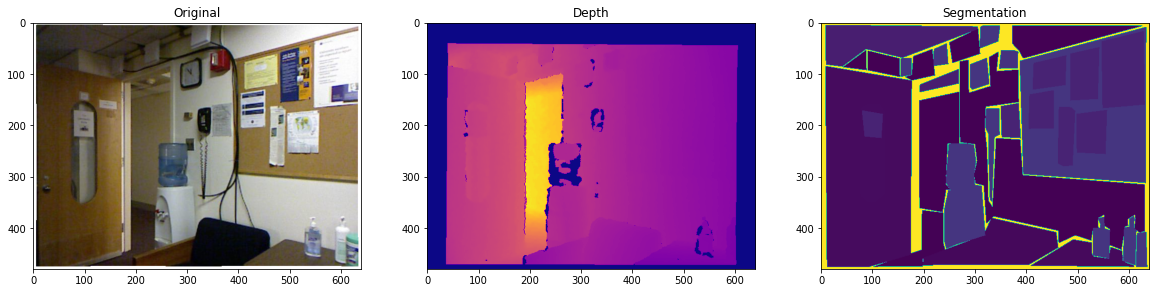

In [10]:
idx = 20

f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20,40))
ax0.imshow(np.array(Image.open(images[idx])))
ax0.set_title("Original")
ax1.imshow(np.array(Image.open(depth[idx])), cmap= "plasma")
ax1.set_title("Depth")
ax2.imshow(np.array(Image.open(seg[idx])))
ax2.set_title("Segmentation")
plt.show()

## Transforms & DataLoader

In [11]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror

In [12]:
from datasets import MMDataset

In [13]:
from model_helpers import set_seed

In [14]:
import torchvision.transforms as transforms

pretrained = True
return_idx = [1, 2, 3, 4, 5, 6]
collapse_ind = [[0, 1], [2, 3], 4, 5]
masks_names = ("segm", "depth")


def line_to_paths_fn(x):
    return x.decode("utf-8").strip("\n").split("\t")

In [17]:
# set seeds
set_seed(42)
depth_scale = 5000.0
img_scale = 1.0 / 255

batch_size = 4
val_batch_size = 4
crop_size = 400
img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

data_dir = "nyud/"
data_val_dir = "nyud/"
data_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]

# data setup
transform_common = [Normalise(*normalise_params), ToTensor()]
transform_train = transforms.Compose(
    [RandomMirror(), RandomCrop(crop_size)] + transform_common
)

transform_val = transforms.Compose(transform_common)

In [18]:
from torch.utils.data import DataLoader

trainloader = DataLoader(
    MMDataset(
        data_file, data_dir, line_to_paths_fn, masks_names, transform=transform_train,),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

valloader = DataLoader(MMDataset(val_file, data_val_dir, line_to_paths_fn, masks_names, transform=transform_val,),
    batch_size=val_batch_size, shuffle=False, num_workers=4, pin_memory=True,drop_last=False,)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 2 — Creating the HydraNet
We now have 2 DataLoaders: one for training, and one for validation/test. <p>

In the next step, we're going to define our model, following the paper [Real-Time Joint Semantic Segmentation and Depth Estimation Using Asymmetric Annotations](https://arxiv.org/pdf/1809.04766.pdf) —— If you haven't read it yet, now is the time.
<p>

> ![](https://d3i71xaburhd42.cloudfront.net/435d4b5c30f10753d277848a17baddebd98d3c31/2-Figure1-1.png)

Our model takes an input RGB image, make it go through an encoder, a lightweight refinenet decoder, and then has 2 heads, one for each task.<p>
Things to note:
* The only **convolutions** we'll need will be 3x3 and 1x1
* We also need a **MaxPooling 5x5**
* **CRP-Blocks** are implemented as Skip-Connection Operations
* **Each Head is made of a 1x1 convolution followed by a 3x3 convolution**, only the data and the loss change there


## 2.1 — Defining the common operations
The first thing we want to do is define the common operations. By that I mean those who will be common to both the encoder, the decoder, and the heads. In this model, we can see that **1x1 convolutions**, as well as **3x3 convolutions** are common.

In [19]:
def conv3x3(in_planes, out_planes, stride=1, bias=False, dilation=1, groups=1):
    "3x3 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, dilation=dilation, bias=bias, groups=groups)

In [20]:
def conv1x1(in_planes, out_planes, stride=1, bias=False, groups=1):
    "1x1 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias, groups=groups)

In [21]:
def batchnorm(in_planes):
    "batch norm 2d"
    return nn.BatchNorm2d(in_planes, affine=True, eps=1e-5, momentum=0.1)

def convbnrelu(in_planes, out_planes, kernel_size, stride=1, groups=1, act=True):
    "conv-batchnorm-relu"
    if act:
        return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_planes),
                             nn.ReLU6(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_planes))

## 2 — Defining the Encoder — A MobileNetv2
![](https://iq.opengenus.org/content/images/2020/11/conv_mobilenet_v2.jpg)

In [22]:
class InvertedResidualBlock(nn.Module):
    """Inverted Residual Block from https://arxiv.org/abs/1801.04381"""
    def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
        super(InvertedResidualBlock, self).__init__()
        intermed_planes = in_planes * expansion_factor
        self.residual = (in_planes == out_planes) and (stride == 1)
        self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                    convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                    convbnrelu(intermed_planes, out_planes, 1, act=False))

    def forward(self, x):
        residual = x
        out = self.output(x)
        if self.residual:
            return (out + residual)
        else:
            return out

In [23]:
class MobileNetv2(nn.Module):
    """MobileNet-v2 definition.
    More information about the model: https://arxiv.org/abs/1801.04381
    Args:
      return_idx (list or int): indices of the layers to be returned
                                during the forward pass.
    Attributes:
      mobilenet_config (list): list of definitions of each layer that includes
                               expansion rate, number of output channels,
                               number of repeats, stride.
      in_planes (int): number of channels in the stem block.
    """

    # expansion rate, output channels, number of repeats, stride
    mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
    ]
    in_planes = 32  # number of input channels
    num_layers = len(mobilenet_config)

    def __init__(self, return_idx=[6]):
        super(MobileNetv2, self).__init__()
        self.return_idx = make_list(return_idx)
        self.layer1 = convbnrelu(
            3, self.in_planes, kernel_size=3, stride=2, act=nn.ReLU6(inplace=True)
        )
        c_layer = 2
        for t, c, n, s in self.mobilenet_config:
            layers = []
            for idx in range(n):
                layers.append(InvertedResidualBlock(self.in_planes,c,expansion_factor=t,stride=s if idx == 0 else 1,))
                self.in_planes = c
            setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
            c_layer += 1
        self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx]

    def forward(self, x):
        outs = []
        x = self.layer1(x)
        outs.append(self.layer2(x))  # 16, x / 2
        outs.append(self.layer3(outs[-1]))  # 24, x / 4
        outs.append(self.layer4(outs[-1]))  # 32, x / 8
        outs.append(self.layer5(outs[-1]))  # 64, x / 16
        outs.append(self.layer6(outs[-1]))  # 96, x / 16
        outs.append(self.layer7(outs[-1]))  # 160, x / 32
        outs.append(self.layer8(outs[-1]))  # 320, x / 32
        return [outs[idx] for idx in self.return_idx]


def mobilenetv2(pretrained=True, **kwargs):
    """Constructs the mobilenet-v2 network.
    Args:
      pretrained (bool): whether to load pre-trained weights.
    Returns:
      `nn.Module` instance.
    """
    model = MobileNetv2(**kwargs)
    if pretrained:
        state_dict = torch.load("mobilenetv2-e6e8dd43.pth")
        model.load_state_dict(state_dict)
    return model

## Defining the Decoder - A Multi-Task Lighweight RefineNet
![](https://drsleep.github.io/images/rf_arch.png)

In [24]:
class CRPBlock(nn.Module):
    """CRP definition"""
    def __init__(self, in_planes, out_planes, n_stages, groups=False):
        super(CRPBlock, self).__init__()
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv1x1(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False, groups=in_planes if groups else 1))
        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
            x = top + x
        return x

In [25]:
class MTLWRefineNet(nn.Module):
    """Multi-Task Light-Weight RefineNet for Dense per-pixel tasks.
    More information about the model: https://arxiv.org/abs/1809.04766
    Args:
      input_sizes (int, or list): number of channels for each input.
      collapse_ind (list): which input layers should be united together
                           (via element-wise summation) before CRP.
      num_classes (int or list): number of output channels per each head.
      agg_size (int): common filter size.
      n_crp (int): number of CRP layers in a single CRP block.
    """

    def __init__(self, input_sizes, collapse_ind, num_classes, agg_size=256, n_crp=4):
        super(MTLWRefineNet, self).__init__()

        stem_convs = nn.ModuleList()
        crp_blocks = nn.ModuleList()
        adapt_convs = nn.ModuleList()
        heads = nn.ModuleList()

        input_sizes = make_list(input_sizes)
        # Reverse since we recover information from the end
        input_sizes = list(reversed(input_sizes))
        # No reverse for collapse indices is needed
        self.collapse_ind = make_list(collapse_ind)
        groups = [False] * len(self.collapse_ind)
        groups[-1] = True

        for size in input_sizes:
            stem_convs.append(conv1x1(size, agg_size, bias=False))

        for group in groups:
            crp_blocks.append(self._make_crp(agg_size, agg_size, n_crp, group))
            adapt_convs.append(conv1x1(agg_size, agg_size, bias=False))

        self.stem_convs = stem_convs
        self.crp_blocks = crp_blocks
        self.adapt_convs = adapt_convs[:-1]

        num_classes = make_list(num_classes)
        for n_out in num_classes:
            heads.append(
                nn.Sequential(
                    conv1x1(agg_size, agg_size, groups=agg_size, bias=False),
                    nn.ReLU6(inplace=False),
                    conv3x3(agg_size, n_out, bias=True),
                )
            )

        self.heads = heads
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, xs):
        xs = make_list(xs)
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)
        # Collapse layers
        c_xs = [
            sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind
        ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))
        return outs

    @staticmethod
    def _make_crp(in_planes, out_planes, stages, groups):
        """Creating Light-Weight Chained Residual Pooling (CRP) block.
        Args:
          in_planes (int): number of input channels.
          out_planes (int): number of output channels.
          stages (int): number of times the design is repeated
                        (with new weights)
          groups (bool): whether to do groupwise convolution inside CRP.
        Returns:
          `nn.Sequential` of CRP layers.
        """
        layers = [CRPBlock(in_planes, out_planes, stages, groups)]
        return nn.Sequential(*layers)

# 3 — Train the Model

In [26]:
from model_helpers import load_state_dict, maybe_cast_target_to_long, get_input_and_targets, create_optim, get_args
from utils import MeanIoU, RMSE

In [27]:
def compute_params(model):
    """Compute the total number of parameters.
    Args:
      model (nn.Module): PyTorch model.
    Returns:
      Total number of parameters - both trainable and non-trainable (int).
    """
    return sum([p.numel() for p in model.parameters()])

In [28]:
def train(
    model, opts, crits, dataloader, loss_coeffs=(1.0,), freeze_bn=False, grad_norm=0.0
):
    """Full Training Pipeline.
    Supports multiple optimisers, multiple criteria, \
    multiple losses, multiple outputs.
    Assumes that the model.eval() property has been set up properly before the\
     function call, that the dataloader outputs have the correct type, that \
     the model outputs do not require any post-processing bar the upsampling \
     to the target size.
    Criteria, loss_coeff, and model's outputs all must have the same length, \
    and correspond to the same keys as in the ordered dict of dataloader's \
    sample.
    Args:
        model : PyTorch model object.
        opts  : list of optimisers.
        crits : list of criterions.
        dataloader : iterable over samples.
                     Each sample must contain `image` key and
                     >= 1 optional keys.
        loss_coeffs : list of coefficients for each loss term.
        freeze_bn: whether to freeze batch norm parameters in the module.
        grad_norm: if > 0, clip gradients' norm to this value.
    """
    model.train()
    if freeze_bn:
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
    device = next(model.parameters()).device
    opts = make_list(opts)
    crits = make_list(crits)
    loss_coeffs = make_list(loss_coeffs)
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input, targets = get_input_and_targets(
            sample=sample, dataloader=dataloader, device=device
        )
        outputs = model(input)
        outputs = make_list(outputs)
        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            loss += loss_coeff * crit(
                F.interpolate(
                    out, size=target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                target.squeeze(dim=1),
            )
        for opt in opts:
            opt.zero_grad()
        loss.backward()
        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

In [29]:
def trainbal(model, dataloader):
    """Full Training Pipeline with balanced model.
    Assumes that the model.eval() property has been set up properly \
    before the function call, that the dataloader outputs have the correct type,\
    that the model outputs do not require any post-processing bar \
    the upsampling to the target size.
    Args:
        model : PyTorch model object.
        dataloader : iterable over samples.
                     Each sample must contain `image` key and
                     >= 1 optional keys.
    """
    device = next(model.parameters()).device
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input, targets = get_input_and_targets(
            sample=sample, dataloader=dataloader, device=device
        )
        loss = model(input, targets)
        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

In [30]:
def validate(model, metrics, dataloader):
    """Full Validation Pipeline.
    Support multiple metrics (but 1 per modality), multiple outputs.
    Assumes that the dataloader outputs have the correct type, that the model \
    outputs do not require any post-processing bar the upsampling \
    to the target size.
    Metrics and model's outputs must have the same length, and correspond to \
    the same keys as in the ordered dict of dataloader's sample.
    Args:
        model : PyTorch model object.
        metrics  : list of metric classes. Each metric class must have update
                   and val functions, and must have 'name' attribute.
        dataloader : iterable over samples.
                     Each sample must contain `image` key and
                     >= 1 optional keys.
    """
    device = next(model.parameters()).device
    model.eval()
    metrics = make_list(metrics)
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            input, targets = get_input_and_targets(
                sample=sample, dataloader=dataloader, device=device
            )
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]
            outputs = model(input)
            outputs = make_list(outputs)
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(
                        out, size=target.shape[1:], mode="bilinear", align_corners=False
                    )
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

In [31]:
from model_helpers import Saver, make_list

In [32]:
import operator 
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [33]:
from utils import InvHuberLoss, AverageMeter

In [34]:
from tqdm import tqdm
# model setup
num_classes = (40, 1)

optim_enc = "SGD"
optim_dec = "SGD"
lr_dec = 1e-2
lr_enc = 1e-3
mom_dec = 0.9
wd_dec = 1e-5
wd_enc = 1e-5
mom_enc = 0.9
loss_coeffs = (0.5, 0.5)  # equal weights per task

ignore_index = 255
ignore_depth = 0

crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()

crop_size = 400
batch_size = 4
val_batch_size = 4
n_epochs = 1000
val_every = 5

enc = mobilenetv2(pretrained=pretrained, return_idx=return_idx)
dec = MTLWRefineNet(enc._out_c, collapse_ind, num_classes)

model1 = nn.DataParallel(nn.Sequential(enc, dec).cuda())#pu()) # or .cuda()


print("Model has {} parameters".format(compute_params(model1)))

start_epoch, _, state_dict = saver.maybe_load(
    ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],
)

load_state_dict(model1, state_dict)

if start_epoch is None:
    start_epoch = 0

# optim setup
optims = [
          create_optim(
        optim_enc, enc.parameters(), lr=lr_enc, momentum=mom_enc, weight_decay=wd_enc
    ),
    create_optim(
        optim_dec, dec.parameters(), lr=lr_dec, momentum=mom_dec, weight_decay=wd_dec
    ),
]

# schedulers
opt_scheds = []
for opt in optims:
    opt_scheds.append(
        torch.optim.lr_scheduler.MultiStepLR(
            opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1
        )
    )

for i in range(start_epoch, n_epochs):
    for sched in opt_scheds:
        sched.step(i)
    model1.train()
    print("Epoch {:d}".format(i))
    train(model1, optims, [crit_segm, crit_depth], trainloader, loss_coeffs)
    if i % val_every == 0:
        metrics = [
            MeanIoU(num_classes[0]),
            RMSE(ignore_val=ignore_depth),
        ]
        model1.eval()
        with torch.no_grad():
            vals = validate(model1, metrics, valloader)
        saver.maybe_save(
            new_val=vals, dict_to_save={"state_dict": model1.state_dict(), "epoch": i}
        )

RuntimeError: ignored